# Import Required Libraries
Import necessary libraries such as NumPy, Pandas, and Matplotlib.

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.decomposition import PCA


# Load and Preprocess the Dataset
Load the Breast Cancer Wisconsin dataset and preprocess it, including handling missing values if any.

In [111]:
# Load and Preprocess the Dataset

# Load the Breast Cancer Wisconsin dataset from the UCI Machine Learning Repository
data = load_breast_cancer()
data


{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [112]:
df = pd.DataFrame(data.data, columns=data.feature_names)
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
y = np.where(y == 0,-1,1)
y = y.astype('float').reshape(-1,1)
scaler = StandardScaler()
X = scaler.fit_transform(X)



### Correlation seaborn plot just to have a general view of the dataset's correlation.

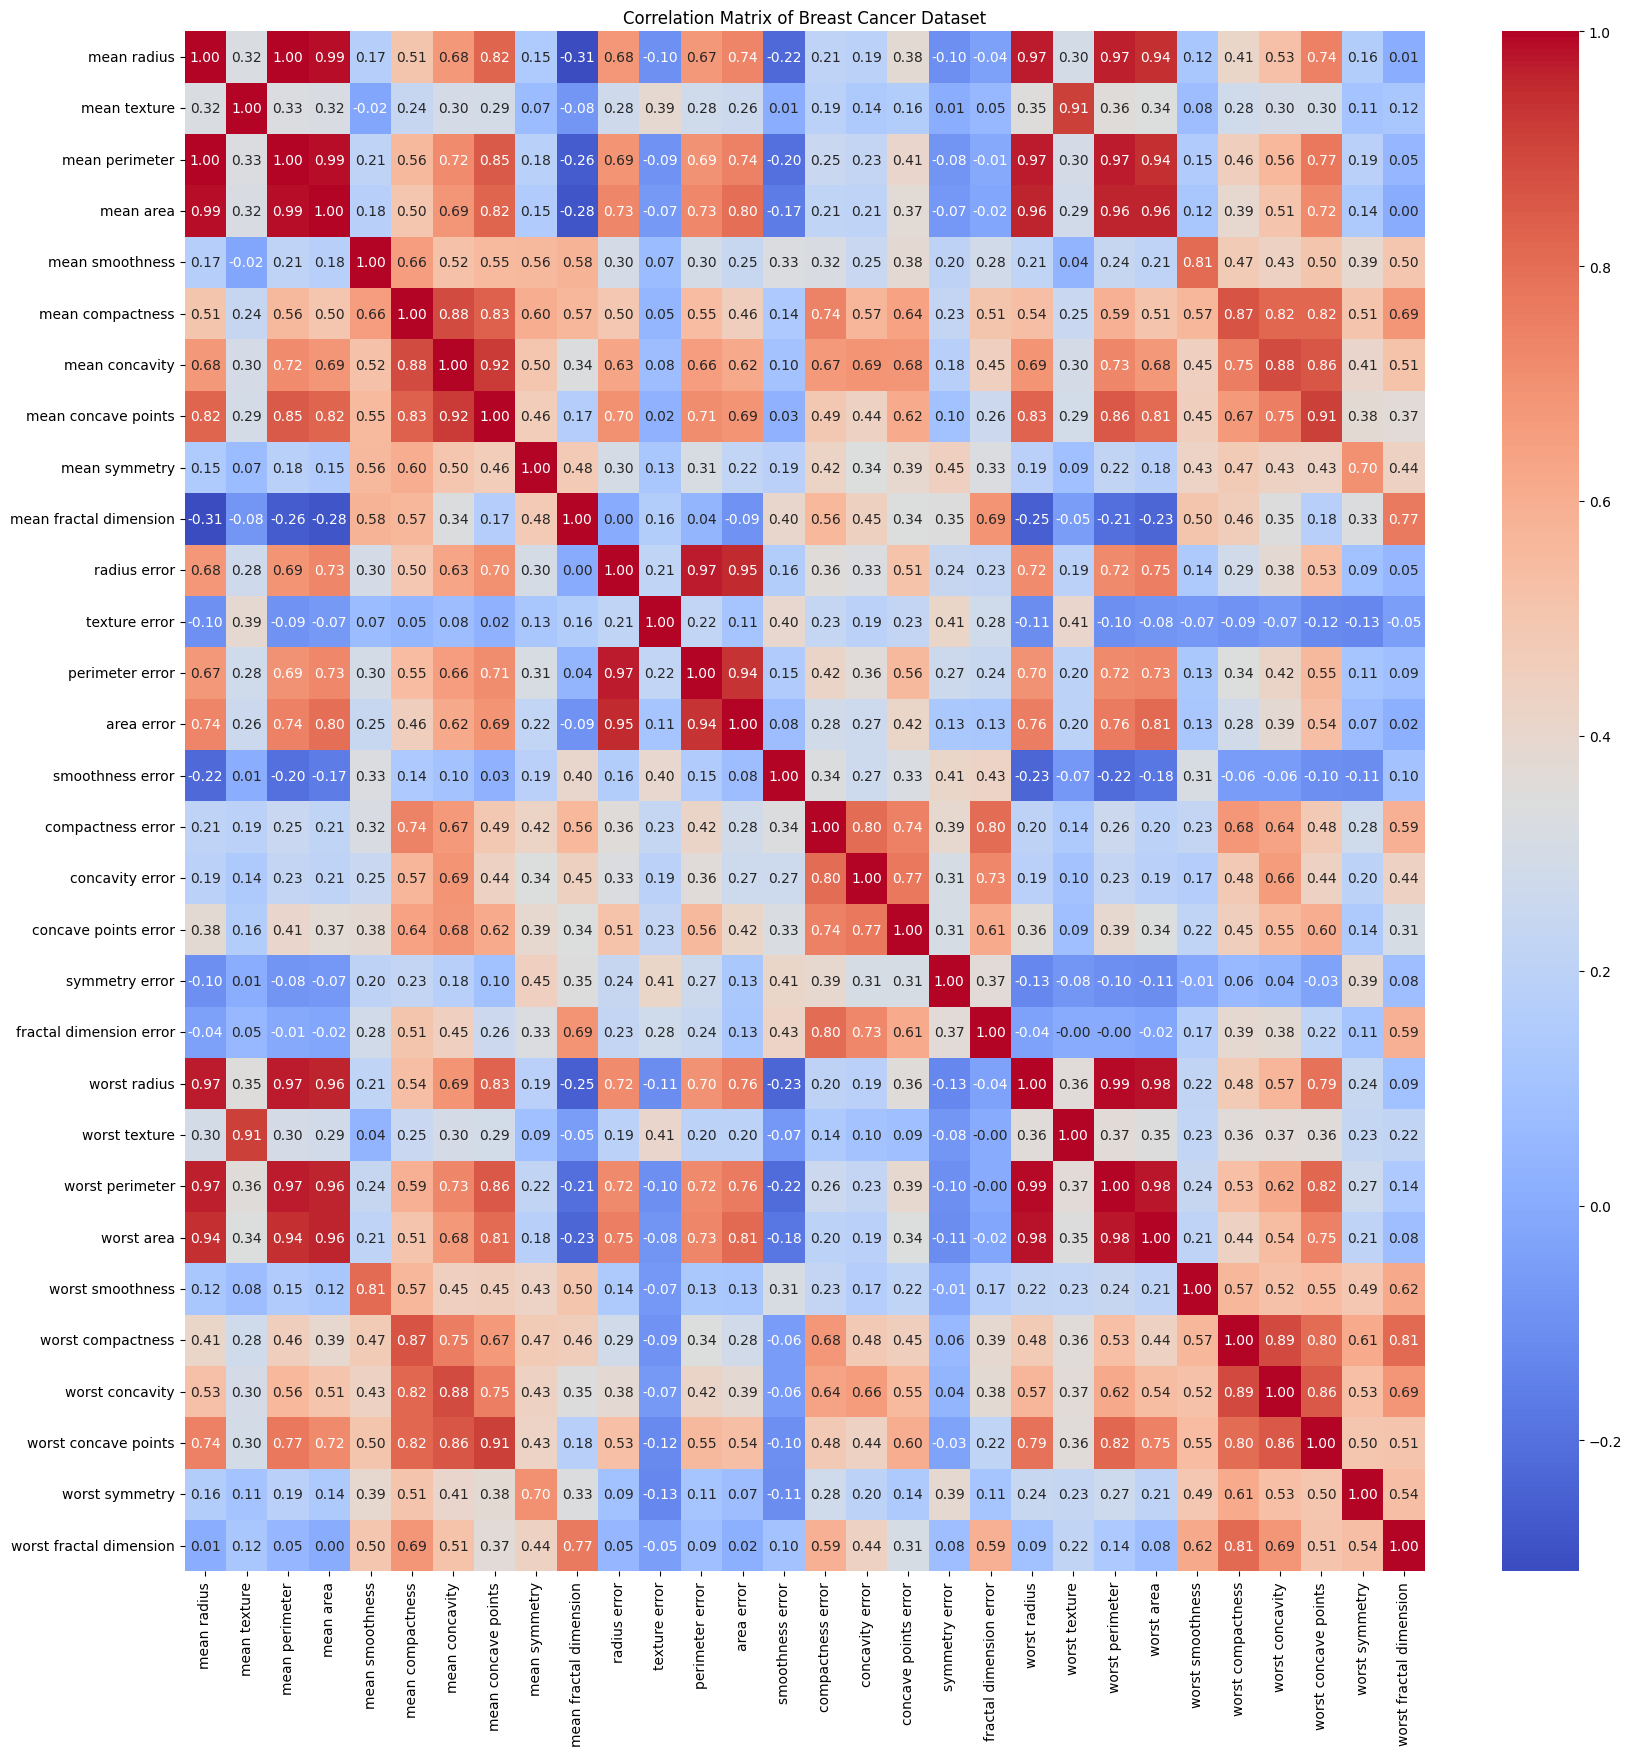

In [120]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Breast Cancer Dataset')
plt.show()

## Scale the features 

In [114]:
def scale (X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    #standardize the features
    X = (X - mean) / std
    return X

# Split the Dataset into Training and Testing Sets
Split the dataset into training and testing subsets to evaluate the model's performance.

In [115]:
# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Class Implemetation of SVM

In [ ]:
import numpy as np
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers


class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None

    def fit(self, X, y):
        #Calculate the matricies for SVM QP formulation
        N = X.shape[0]
        H = np.outer(y, y) * np.dot(X, X.T)
        P = cvxopt_matrix(H)
        q = cvxopt_matrix(-np.ones(N))
        A = cvxopt_matrix(y.astype(float), (1, N))
        b = cvxopt_matrix(0.0)
        g = np.vstack((-np.eye(N), np.eye(N)))
        G = cvxopt_matrix(g)
        h1 = np.hstack([np.zeros(N), np.ones(N)*self.C])
        h = cvxopt_matrix(h1)
        #Solver Options
        cvxopt_solvers.options['abstol'] = 1e-10
        cvxopt_solvers.options['reltol'] = 1e-10
        cvxopt_solvers.options['feastol'] = 1e-10
        

        solution = cvxopt_solvers.qp(P, q, G, h, A, b)
        lambdaa = np.array(solution['x'])
        #Calculate w using lambda.
        self.w = np.sum(lambdaa * y * X, axis=0)

        #Calculate Support vectors
        sv_index= np.where(lambdaa > 1e-5)[0]
        sv_lambdaa = lambdaa[sv_index]
        sv_x = X[sv_index]
        sv_y =  y[sv_index]
        
        sv_plus = sv_x[np.where(sv_y > 0)[0]] # +1 support vector
        sv_minus = sv_x[np.where(sv_y < 0)[0]]# -1 support vector

        #Calculate b
        self.b = np.min(np.dot(sv_minus, self.w)) - np.max(np.dot(sv_plus, self.w))

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

## Compare Results with Scikit-Learn SVM

In [117]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Initialize and train the custom SVM
svm_custom = SVM(C=1.0)
svm_custom.fit(X_train, y_train)

# Predict on the test set using the custom SVM
y_pred_custom = svm_custom.predict(X_test)

# Calculate accuracy for the custom SVM
accuracy_custom = accuracy_score(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom)
recall_custom = recall_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom)

print(f"Custom SVM Accuracy: {accuracy_custom * 100:.2f}%")


# Initialize and train the sklearn SVM
svm_sklearn = SVC(C=1.0, kernel='linear')
svm_sklearn.fit(X_train, y_train)

# Predict on the test set using the sklearn SVM
y_pred_sklearn = svm_sklearn.predict(X_test)

# Calculate accuracy for the sklearn SVM
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)


print(f"Sklearn SVM Accuracy: {accuracy_sklearn * 100:.2f}%")


     pcost       dcost       gap    pres   dres
 0: -9.3128e+01 -9.9126e+02  5e+03  3e+00  7e-14
 1: -5.9564e+01 -6.0030e+02  1e+03  5e-01  4e-14
 2: -4.3824e+01 -3.2550e+02  5e+02  2e-01  3e-14
 3: -3.1760e+01 -1.6889e+02  2e+02  8e-02  2e-14
 4: -2.5638e+01 -8.5083e+01  1e+02  3e-02  1e-14
 5: -2.3528e+01 -4.7122e+01  4e+01  1e-02  1e-14
 6: -2.2537e+01 -2.9337e+01  1e+01  2e-03  1e-14
 7: -2.2885e+01 -2.4695e+01  2e+00  1e-15  1e-14
 8: -2.3456e+01 -2.3910e+01  5e-01  9e-16  1e-14
 9: -2.3604e+01 -2.3703e+01  1e-01  1e-15  1e-14
10: -2.3648e+01 -2.3650e+01  2e-03  2e-15  1e-14
11: -2.3649e+01 -2.3649e+01  2e-05  1e-15  1e-14
12: -2.3649e+01 -2.3649e+01  2e-07  9e-16  1e-14
13: -2.3649e+01 -2.3649e+01  2e-09  1e-15  1e-14
Optimal solution found.
Custom SVM Accuracy: 91.23%
Sklearn SVM Accuracy: 98.25%


/Users/shivvinnybhutani/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Testing C values for the custom SVM

     pcost       dcost       gap    pres   dres
 0: -9.3128e+01 -9.9126e+02  5e+03  3e+00  7e-14
 1: -5.9564e+01 -6.0030e+02  1e+03  5e-01  4e-14
 2: -4.3824e+01 -3.2550e+02  5e+02  2e-01  3e-14
 3: -3.1760e+01 -1.6889e+02  2e+02  8e-02  2e-14
 4: -2.5638e+01 -8.5083e+01  1e+02  3e-02  1e-14
 5: -2.3528e+01 -4.7122e+01  4e+01  1e-02  1e-14
 6: -2.2537e+01 -2.9337e+01  1e+01  2e-03  1e-14
 7: -2.2885e+01 -2.4695e+01  2e+00  1e-15  1e-14
 8: -2.3456e+01 -2.3910e+01  5e-01  9e-16  1e-14
 9: -2.3604e+01 -2.3703e+01  1e-01  1e-15  1e-14
10: -2.3648e+01 -2.3650e+01  2e-03  2e-15  1e-14
11: -2.3649e+01 -2.3649e+01  2e-05  1e-15  1e-14
12: -2.3649e+01 -2.3649e+01  2e-07  9e-16  1e-14
13: -2.3649e+01 -2.3649e+01  2e-09  1e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0661e+02 -6.0159e+03  2e+04  1e+00  2e-13
 1: -1.3674e+02 -2.5718e+03  4e+03  2e-01  1e-13
 2: -9.2762e+01 -1.3429e+03  2e+03  9e-02  7e-14
 3: -6.5434e+01 -6.7885e+02  1e+03  3e-02  4e-1

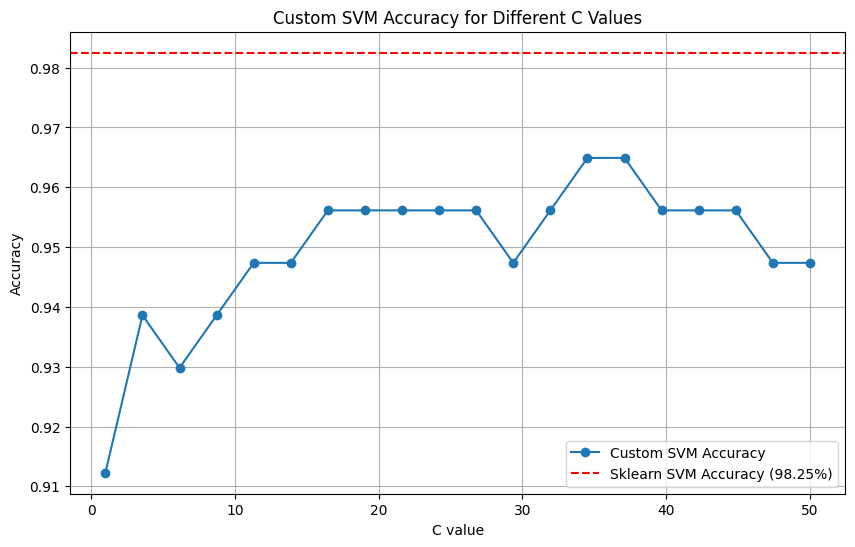

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define a range of 20 C values to test between 1 and 50
C_values = np.linspace(1, 50, 20)
accuracies = []

# Variables to store the best C value and its corresponding accuracy
best_C = None
best_accuracy = 0

# Test the custom SVM with different C values
for C in C_values:
    svm_custom = SVM(C=C)
    svm_custom.fit(X_train, y_train)
    y_pred_custom = svm_custom.predict(X_test)
    accuracy_custom = accuracy_score(y_test, y_pred_custom)
    accuracies.append(accuracy_custom)
    
    # Update the best C value if the current accuracy is higher
    if accuracy_custom > best_accuracy:
        best_accuracy = accuracy_custom
        best_C = C

# Print the optimal C value and its corresponding accuracy
print(f"Optimal C value: {best_C}")
print(f"Accuracy with optimal C value: {best_accuracy * 100:.2f}%")

# Plot the accuracies for different C values
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o', label='Custom SVM Accuracy')
plt.axhline(y=0.9825, color='r', linestyle='--', label='Sklearn SVM Accuracy (98.25%)')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Custom SVM Accuracy for Different C Values')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Descision Boundary With PCA and Scikit

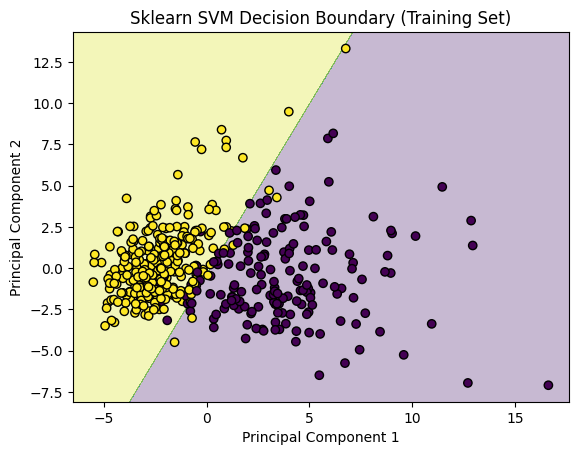

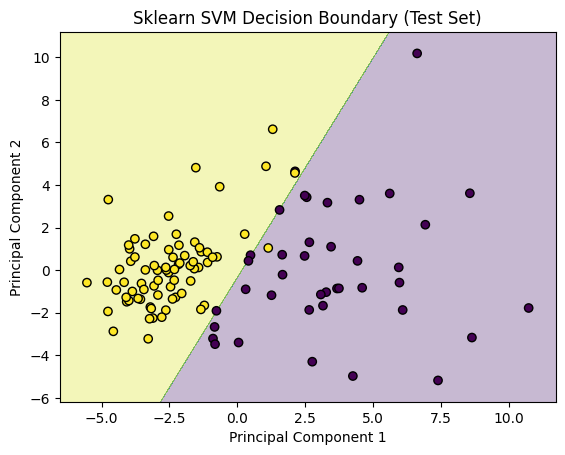

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the sklearn SVM on the PCA data
svm_sklearn_pca = SVC(C=1.0, kernel='linear')
svm_sklearn_pca.fit(X_train_pca, y_train.ravel())

# Plot the decision boundary
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Plot the decision boundary for the training set
plot_decision_boundary(svm_sklearn_pca, X_train_pca, y_train.ravel(), "Sklearn SVM Decision Boundary (Training Set)")

# Plot the decision boundary for the test set
plot_decision_boundary(svm_sklearn_pca, X_test_pca, y_test.ravel(), "Sklearn SVM Decision Boundary (Test Set)")